# Model Iteration 2
This model iteration is used to predict survival rate on Titanic using Python
- Overall Highest Score: 0.78947 (from Model Iteration 1)
- Highest Score from Model Iteration 2: 0.77990

Data Source: https://www.kaggle.com/c/titanic

#### Overview
Tried out 
- Various type of regression: Linear, Logistic, Random Forest, Gradient Boosting
- Combination of different regressions
- Selection of best predictors
- Separating female and male data

## Code

Importing data as pandas dataframe

In [1]:
import pandas as pd
import numpy as np
# import re
import operator

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.feature_selection import SelectKBest, f_classif

In [17]:
"""Importing Data as pandas dataframe"""
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

From the previous iteration, I noticed that assigning values to variables created unwanted relationships. For example, the embarkment ports, S, Q and C does not have correlation but making S = 1, Q = 2, and C = 3 seems like there is a relationship between the ports.
For this iteration, I made new columns of binary values so that the model can learn from raw data.

- The format functions groups the data in each column into different classification that i've preassigned and numbers them in order.
- The divide functions makes the different groups in each columns into distinct columns with binary data (1 if it is classified as the group, 0 otherwise)
- The _wo_sex function is for later when I predicted for male and female data separately

In [3]:
"""Functions for formatting data"""

#df_train = pd.read_csv("train.csv")
#df_test = pd.read_csv("test.csv")

def format(df):
    """ 
    formats all the data in the dataframe(df)
    """
    format_age(df)    
    format_fare(df)    
    format_embarked(df)  
    format_sex(df)    
    format_familysize(df)
    format_namelength(df)
    return

def format_wo_sex(df):
    """ 
    formats all the data in the dataframe(df) except sex
    """
    format_age(df)    
    format_fare(df)    
    format_embarked(df)   
    format_familysize(df)
    format_namelength(df)
    return
    
def divide_all(df):
    """
    divide formatted data and
    returns new feature name as a list
    """
    pclass_column = divide(df, 'Pclass')
    age_column = divide(df, 'Age')
    fare_column = divide(df, 'Fare')
    embarked_column = divide(df, 'Embarked')
    sex_column = divide(df, 'Sex')
    familysize_column = divide(df, 'FamilySize')
    return pclass_column + age_column + fare_column + embarked_column + sex_column + familysize_column

def divide_all_wo_sex(df):
    """
    divide formatted data and
    returns new feature name as a list
    """
    pclass_column = divide(df, 'Pclass')
    age_column = divide(df, 'Age')
    fare_column = divide(df, 'Fare')
    embarked_column = divide(df, 'Embarked')
    familysize_column = divide(df, 'FamilySize')
    return pclass_column + age_column + fare_column + embarked_column + familysize_column


def format_age(df):
    """
    grouping age into agegroups (years old)
    0: unknown age
    1: infants (0-1) & toddlers (1-3)
    2: preschoolers (3-5)
    3: middle childhood (6-11)
    4: young teen (12-14)
    5: teenagers (15-17)
    6: young adults (18-35)
    7: middle-aged adults (36-55)
    8: young older aduls (55-60)
    9: retired (>60)
    
    """
    ag = {1:[0,3], 2:[3,5], 3:[5,11], 4:[11,14], 5:[14,17], 6:[17,35], 7:[35,55], 8:[55,60], 9:[60,150]}
    df['Age'] = df['Age'].fillna(0)
    
    for i in range(1,10):
        df.loc[(df['Age'] > ag[i][0]) & (df['Age'] <= ag[i][1]), 'Age'] = i
    return

def format_fare(df):
    """
    grouping fare by amount the passenger paid
    0: unknown
    1: 0-10
    2: 10-20
    3: 20-30
    4: 30-40
    5: 40-550
    """
    fg = {1:[0,10], 2:[10,20], 3:[20,30], 4:[30,40], 5:[40,550]}
    df['Fare'] = df['Fare'].fillna(0)
    
    for i in range(1,6):
        df.loc[(df['Fare'] > fg[i][0]) & (df['Fare'] <= fg[i][1]), 'Fare'] = i
    return

def format_embarked(df):
    """
    change the value from string to float 
    for dividing up the columns later
    0: no data available
    1: Southampton
    2: Cherbourg
    3: Queenstown
    """
    df['Embarked'] = df['Embarked'].fillna(0)
    
    df.loc[df["Embarked"] == 'S', "Embarked"] =1
    df.loc[df["Embarked"] == 'C', "Embarked"] =2
    df.loc[df["Embarked"] == 'Q', "Embarked"] =3
    return

def format_sex(df):
    """
    change the value from string to float 
    for dividing up the columns later
    1: male
    2: female
    """
    df.loc[df['Sex'] == 'male', 'Sex'] = 1
    df.loc[df['Sex'] == 'female', 'Sex'] = 2
    return
    
def format_familysize(df):
    """
    Generate column named FamilySize 
    which is the sum of number of family member onboard
    
    Group by familysize
    0: unknown
    1: 1
    2: 2
    3: 3-5
    4: >5
    5: 0
    """
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['FamilySize'] = df['FamilySize'].fillna(0)
    
    df.loc[(df['FamilySize'] > 2) & (df['FamilySize'] <= 5), 'FamilySize'] = 3
    df.loc[df['FamilySize'] > 5, 'FamilySize'] = 4
    df.loc[df['FamilySize'] == 0, 'FamilySize'] = 5
    return
    
def format_namelength(df):
    """
    Generate column named NameLength
    which shows the length of the name
    """
    df["NameLength"] = df["Name"].apply(lambda x: len(x))
    return

def divide(df, column):
    """
    Create new columns for column such that the values are 1 or 0
    returns name of the newly generated columns(features) in a list
    
    example:
    divide(df, 'Sex')
    will result in columns Sex1 and Sex2, such that
    Sex1 will have value 1 for all males and 0 for the rest & unknown
    Sex2 will have value 1 for all females and 0 for the rest & unknown
    """
    columns = []
    for i in df[column].unique():
        if i == 0:
            continue
        else:
            column_name = column + str(int(i))
            df[column_name] = df[column]
            columns.append(column_name)
            df.loc[df[column_name] != i, column_name] = 0
            df.loc[df[column_name] == i, column_name] = 1
    return columns

Improvements that can be made
- use get_dummies from pandas
- use fit_transform from LabelEncoder

In [4]:
"""Formatting data"""
format(df_train)
format(df_test)
train_columns = divide_all(df_train)
test_columns = divide_all(df_test)

#### Checking for difference in columns (for test and train data)

In [5]:
"""Checking to see if the columns of test data and train data are the same"""
train_columns.sort()
test_columns.sort()
if train_columns == test_columns:
    predictors = train_columns

print train_columns == test_columns

True


### Trying out different types of regression

In [6]:
"""Using Linear Regression"""

alg = LinearRegression()
kf = KFold(df_train.shape[0], n_folds=3, random_state=1)

predictions = []

for train, test in kf:
    # The predictors we're using the train the algorithm (only take the rows in the train folds)
    train_predictors = (df_train[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = df_train["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # make predictions on the test fold
    test_predictions = alg.predict(df_train[predictors].iloc[test,:])
    predictions.append(test_predictions)

# concatenate the predictions in three seperate numpy array on axis 0
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

accuracy = sum(predictions[predictions == df_train["Survived"]]) / len(predictions)
print accuracy

0.804713804714


/home/jkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [8]:
"""Using LogisticRegression"""
# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(alg, df_train[predictors], df_train["Survived"], cv=3)

print(scores.mean())

0.799102132435


In [9]:
"""Using RandomForest"""
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
# Compute the accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(alg, df_train[predictors], df_train["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.817059483726


obtained submission score of 0.75120

#### Finding the best features by plotting

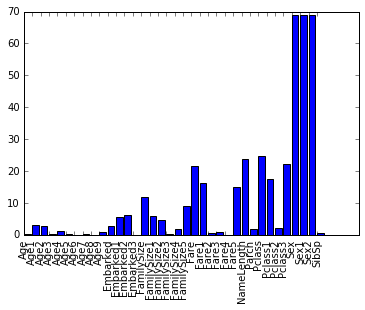

In [10]:
"""Finding the best features"""

import matplotlib.pyplot as plt
%matplotlib inline

predictors_original = ['Embarked', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'NameLength']
predictors = predictors + predictors_original
predictors.sort()

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(df_train[predictors], df_train["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores for different features
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

Determining the best predictors 
- Sex (predicted similarly to Sex1 and Sex2 so we can just use sex)
- Pclass/ Pclass1 + Pclass2 (Pclass3 does not seem to affect the outcome very much)
- Fare/ Fare1 (other fares seem have little effect compared to fare 1)
- FamilySize/ FamilySize1 + FamilySize2 + FamilySize5 (either no family, family size 1 and family size 2 affected the prediction the most)
- Embarked/ Embarked1 + Embarked2 (knowing Embarked3(Queens) did not affect the outcome very much)
- Predicting using certain age groups (1,2,4) is better than predicting with the entire age group

Selecting the best predictors and applying on RandomForest

In [11]:
# Picking out the best features.
predictors_filtered = ['Age1', 'Age2', 'Age4', 'Age9',
              'Embarked1',
              'FamilySize', 
              'Fare1', 'Fare2', 
              'NameLength',
              'Pclass1', 'Pclass2',
              'Sex']

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
scores = cross_validation.cross_val_score(alg, df_train[predictors_filtered], df_train["Survived"], cv=3)

print(scores.mean())

0.810325476992


It actually decreased the score

#### Predicting using ensembling of RandomForestClassifier and LogisticRegression

In [12]:
"""Making predictions on test data"""
# Train the algorithm using all the training data
alg.fit(df_train[predictors], df_train["Survived"])

# Make predictions using the test set.
predictions = alg.predict(df_test[predictors])

In [13]:
"""Ensembling"""

# The algorithms we want to ensemble.
algorithms = [
    #[GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors + predictors_original],
    [RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2), predictors_filtered],
    [LogisticRegression(random_state=1), predictors], #Use more linear predictors for the logistic regression
]

# Initialize the cross validation folds
kf = KFold(df_train.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = df_train["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(df_train[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(df_train[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == df_train["Survived"]]) / len(predictions)
print(accuracy)

0.810325476992


/home/jkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [14]:
full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(df_train[predictors], df_train["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(df_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)

obtained score of 0.76555

In [15]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('titanic_mi2.csv', index=False)

### Applying machine learning separately on female and male data

Trying out different model did not improve the score as much as I hoped so I am going to try separating the female and male data again like the Model Iteration 1

In [37]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

"""dividing male and female data"""
df_male_train = df_train[df_train['Sex'] == 'male']
df_female_train = df_train[df_train['Sex'] == 'female']

df_male_test = df_test[df_test['Sex'] == 'male']
df_female_test = df_test[df_test['Sex'] == 'female']

def get_predictors(df_train, df_test):
    """format data and get predictiors as return value"""
    
    """Formatting data"""
    format_wo_sex(df_train)
    format_wo_sex(df_test)
    train_columns = divide_all_wo_sex(df_train)
    test_columns = divide_all_wo_sex(df_test)

    #"""Checking to see if the columns of test data and train data are the same"""
    #train_columns.sort()
    #test_columns.sort()
    #if train_columns == test_columns:
    #    predictors = train_columns
    #else:
    #    predictors = test_columns

    #print train_columns == test_columns
    
    predictors = test_columns
    return predictors

def set_algorithm(predictors):
    algorithms = [
        [LogisticRegression, predictors],
        [RandomForestClassifier(min_samples_split=4), predictors]
    ]
    return algorithms


def en_prediction(df_train, df_test, algorithms):
    full_predictions = []
    for alg, predictors in algorithms:
        # Fit the algorithm using the full training data.
        alg.fit(df_train[predictors], df_train["Survived"])
        # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
        predictions = alg.predict_proba(df_test[predictors].astype(float))[:,1]
        full_predictions.append(predictions)

    # The gradient boosting classifier generates better predictions, so we weight it higher.
    predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
    predictions[predictions <= .5] = 0
    predictions[predictions > .5] = 1
    predictions = predictions.astype(int)
    return predictions

def make_submission(df_test, predictions):
    submission = pd.DataFrame({
            "PassengerId": df_test["PassengerId"],
            "Survived": predictions
        })
    return submission

"""Predicting for male"""
#predictors = get_predictors(df_male_train, df_male_test)
#algorithms = set_algorithm(predictors)
#predictions = en_prediction(df_male_train, df_male_test, algorithms)
#submission_male = make_submission(df_male_test, predictions)

predictors= get_predictors(df_male_train, df_male_test)
alg = RandomForestClassifier(min_samples_split=4, min_samples_leaf=2)
alg.fit(df_male_train[predictors], df_male_train["Survived"])
predictions = alg.predict(df_male_test[predictors])
submission_male = make_submission(df_male_test, predictions)
               
"""Predicting for female"""
#predictors = get_predictors(df_female_train, df_female_test)
#algorithms = set_algorithm(predictors)
#predictions = en_prediction(df_female_train, df_female_test, algorithms)
#submission_female = make_submission(df_female_test, predictions)

predictors = get_predictors(df_female_train, df_female_test)
alg = RandomForestClassifier(min_samples_split=4, min_samples_leaf=2)
alg.fit(df_female_train[predictors], df_female_train["Survived"])
predictions = alg.predict(df_female_test[predictors])
submission_female = make_submission(df_female_test, predictions)


frames = [submission_male, submission_female]
submission = pd.concat(frames)
submission.to_csv('titanic_mi2b.csv', index=False)

/home/jkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

The score is slightly higher than prediction made by applying the regression on both female and male.
- submission score using Logistic Regression for both female and male: 0.77033
- submission score using Random Forest for both female and male: 0.77990

#### Improvements that can be made
- Selecting out the best predictors for the different dataframe (male/ female) and applying only the selected predictors
- Evaluating which regression work best for each dataframe and applying different regressions
- Seperating dataframe into young, middle aged, and old and training them separately


### Reference Source

dataquest
- https://www.dataquest.io/mission/74/getting-started-with-kaggle
- https://www.dataquest.io/mission/75/improving-your-submission